LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [ ]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

In [ ]:
!pip install mosek 
!export PYTHONPATH="$PYTHONPATH:/content"

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem. 
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

In [16]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [ ]:
# Colab additional settings
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"

In [17]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [18]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [19]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [20]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

First we generate return scenario data using Monte Carlo method based on the moments of historical prices.  

In [21]:
# Number of scenarios
T = 99999

# Mean and covariance of historical log-returns.  
m_log, S_log = compute_inputs(df_prices, return_log=True)

# Generate logarithmic return scenarios assuming normal distribution
scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, T)
    
# Convert logarithmic return scenarios to linear return scenarios 
scenarios_lin = np.exp(scenarios_log) - 1

# Scenario probabilities
p = np.ones(T) / T

We would like to optimize the 95% EVaR of the portfolio loss distribution.

In [22]:
# Confidence level
alpha = 0.95

In [23]:
# Primal CVaR formula (for testing)
def CVaR(alpha, p, q):
    # We need to be careful that math index starts from 1 but numpy starts from 0 (matters in formulas like ceil(alpha * T))
    T = q.shape[0]
    
    # Starting index 
    i_alpha = np.sort(np.nonzero(np.cumsum(p) >= alpha)[0])[0]

    # Weight of VaR component in CVaR
    lambda_alpha = (sum(p[:(i_alpha + 1)]) - alpha) / (1 - alpha)    
    
    # CVaR
    sort_idx = np.argsort(q)
    sorted_q = q[sort_idx]
    sorted_p = p[sort_idx]
    cvar = lambda_alpha * sorted_q[i_alpha] + np.dot(sorted_p[(i_alpha + 1):], sorted_q[(i_alpha + 1):]) / (1 - alpha)
    
    return cvar

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [24]:
# s * log(sum_i(p_i * exp(x_i / s))) <= t
def persplogsumexp(M, x, s, p, t):
    n = int(x.getSize())
    u = M.variable(n)
    M.constraint(Expr.hstack(u, Var.repeat(s, n), Expr.sub(x, Var.repeat(t, n))), Domain.inPExpCone())
    M.constraint(Expr.sub(Expr.dot(p, u), s), Domain.lessThan(0.0))
    

def EfficientFrontier(N, T, m, R, p, alpha, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings relative to the initial capital.
        # It is constrained to take only positive values. 
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1.0))
        
        # Auxiliary variables.
        z = M.variable("z", 1, Domain.unbounded())
        t = M.variable("t", 1, Domain.greaterThan(0.0))
        
        # Constraint modeling perspective of log-sum-exp
        persplogsumexp(M, Expr.mul(-R, x), t, p, z)
        
        # Objective
        delta = M.parameter()
        evar_term = Expr.sub(z, Expr.mul(t, np.log(1.0 - alpha)))
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, evar_term)))
        
        # Create DataFrame to store the results.
        columns = ["delta", "obj", "return", "risk", "evar"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
        
            # Solve optimization
            M.solve()
            
            # Check if the solution is an optimal point
            solsta = M.getPrimalSolutionStatus()
            if (solsta != SolutionStatus.Optimal):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!")

            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = z.level()[0] - t.level()[0] * np.log(1.0 - alpha)
            cvar = CVaR(alpha, p, -R @ x.level())
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, cvar] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)
            
            # Check CVaR value using primal formula
            print(f"Relative difference between EVaR and CVaR (%): {(cvar - portfolio_risk) / portfolio_risk * 100}")

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [25]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, _ = compute_inputs(df_prices)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{2}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [26]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=2, num=20)[::-1]
df_result = EfficientFrontier(N, T, m, scenarios_lin, p, alpha, deltas)

Relative difference between EVaR and CVaR (%): -33.34432676419066
Relative difference between EVaR and CVaR (%): -33.37371618745751
Relative difference between EVaR and CVaR (%): -33.4149014284201
Relative difference between EVaR and CVaR (%): -33.47392808411666
Relative difference between EVaR and CVaR (%): -33.556573344857206
Relative difference between EVaR and CVaR (%): -33.67117448159376
Relative difference between EVaR and CVaR (%): -33.8196074218172
Relative difference between EVaR and CVaR (%): -33.96310238892608
Relative difference between EVaR and CVaR (%): -34.09525660055069
Relative difference between EVaR and CVaR (%): -34.215979106237896
Relative difference between EVaR and CVaR (%): -34.184001108131255
Relative difference between EVaR and CVaR (%): -33.99924809867457
Relative difference between EVaR and CVaR (%): -33.55107244935692
Relative difference between EVaR and CVaR (%): -32.44998441879637
Relative difference between EVaR and CVaR (%): -31.683199551038655
Relative

Check the results.

In [27]:
df_result

,delta,obj,return,risk,evar,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,-14.953646,0.347195,0.153008,0.101989,-4.200544e-10,2.380323e-02,1.240762e-01,-2.445711e-10,0.092248,0.529645,2.302280e-01,8.000300e-09
1,69.519280,-10.289742,0.347864,0.153017,0.101949,-5.767600e-10,2.262804e-02,1.224060e-01,-4.865816e-10,0.093044,0.531666,2.302557e-01,6.170187e-08
2,48.329302,-7.047174,0.348830,0.153034,0.101898,-3.315016e-10,2.093293e-02,1.199985e-01,-3.270810e-10,0.094193,0.534583,2.302920e-01,-3.340725e-11
3,33.598183,-4.792609,0.350221,0.153069,0.101831,2.955958e-10,1.849642e-02,1.165299e-01,1.296398e-09,0.095859,0.538783,2.303314e-01,2.299996e-07
4,23.357215,-3.224731,0.352227,0.153141,0.101752,-2.106391e-10,1.499125e-02,1.115321e-01,-2.087788e-10,0.098282,0.544838,2.303571e-01,1.343114e-09
5,16.237767,-2.134014,0.355123,0.153293,0.101677,7.469715e-10,9.950838e-03,1.043194e-01,2.361659e-08,0.101817,0.553571,2.303417e-01,1.645691e-07
6,11.288379,-1.374667,0.359314,0.153608,0.101658,9.289331e-10,2.694257e-03,9.389393e-02,8.585784e-10,0.107019,0.566195,2.301977e-01,5.731995e-08
7,7.847600,-0.845310,0.364520,0.154166,0.101806,-4.110874e-11,2.905935e-07,7.476397e-02,5.899203e-10,0.114536,0.582359,2.283409e-01,7.499860e-09
8,5.455595,-0.475463,0.371640,0.155272,0.102332,1.528255e-09,4.045844e-07,4.510294e-02,3.855314e-09,0.125599,0.604721,2.245770e-01,7.249099e-08
9,3.792690,-0.215685,0.382035,0.157598,0.103674,3.590687e-09,6.469236e-08,2.101860e-03,3.821032e-09,0.142229,0.637272,2.183970e-01,1.440152e-07


## Visualize the results

Plot the efficient frontier.

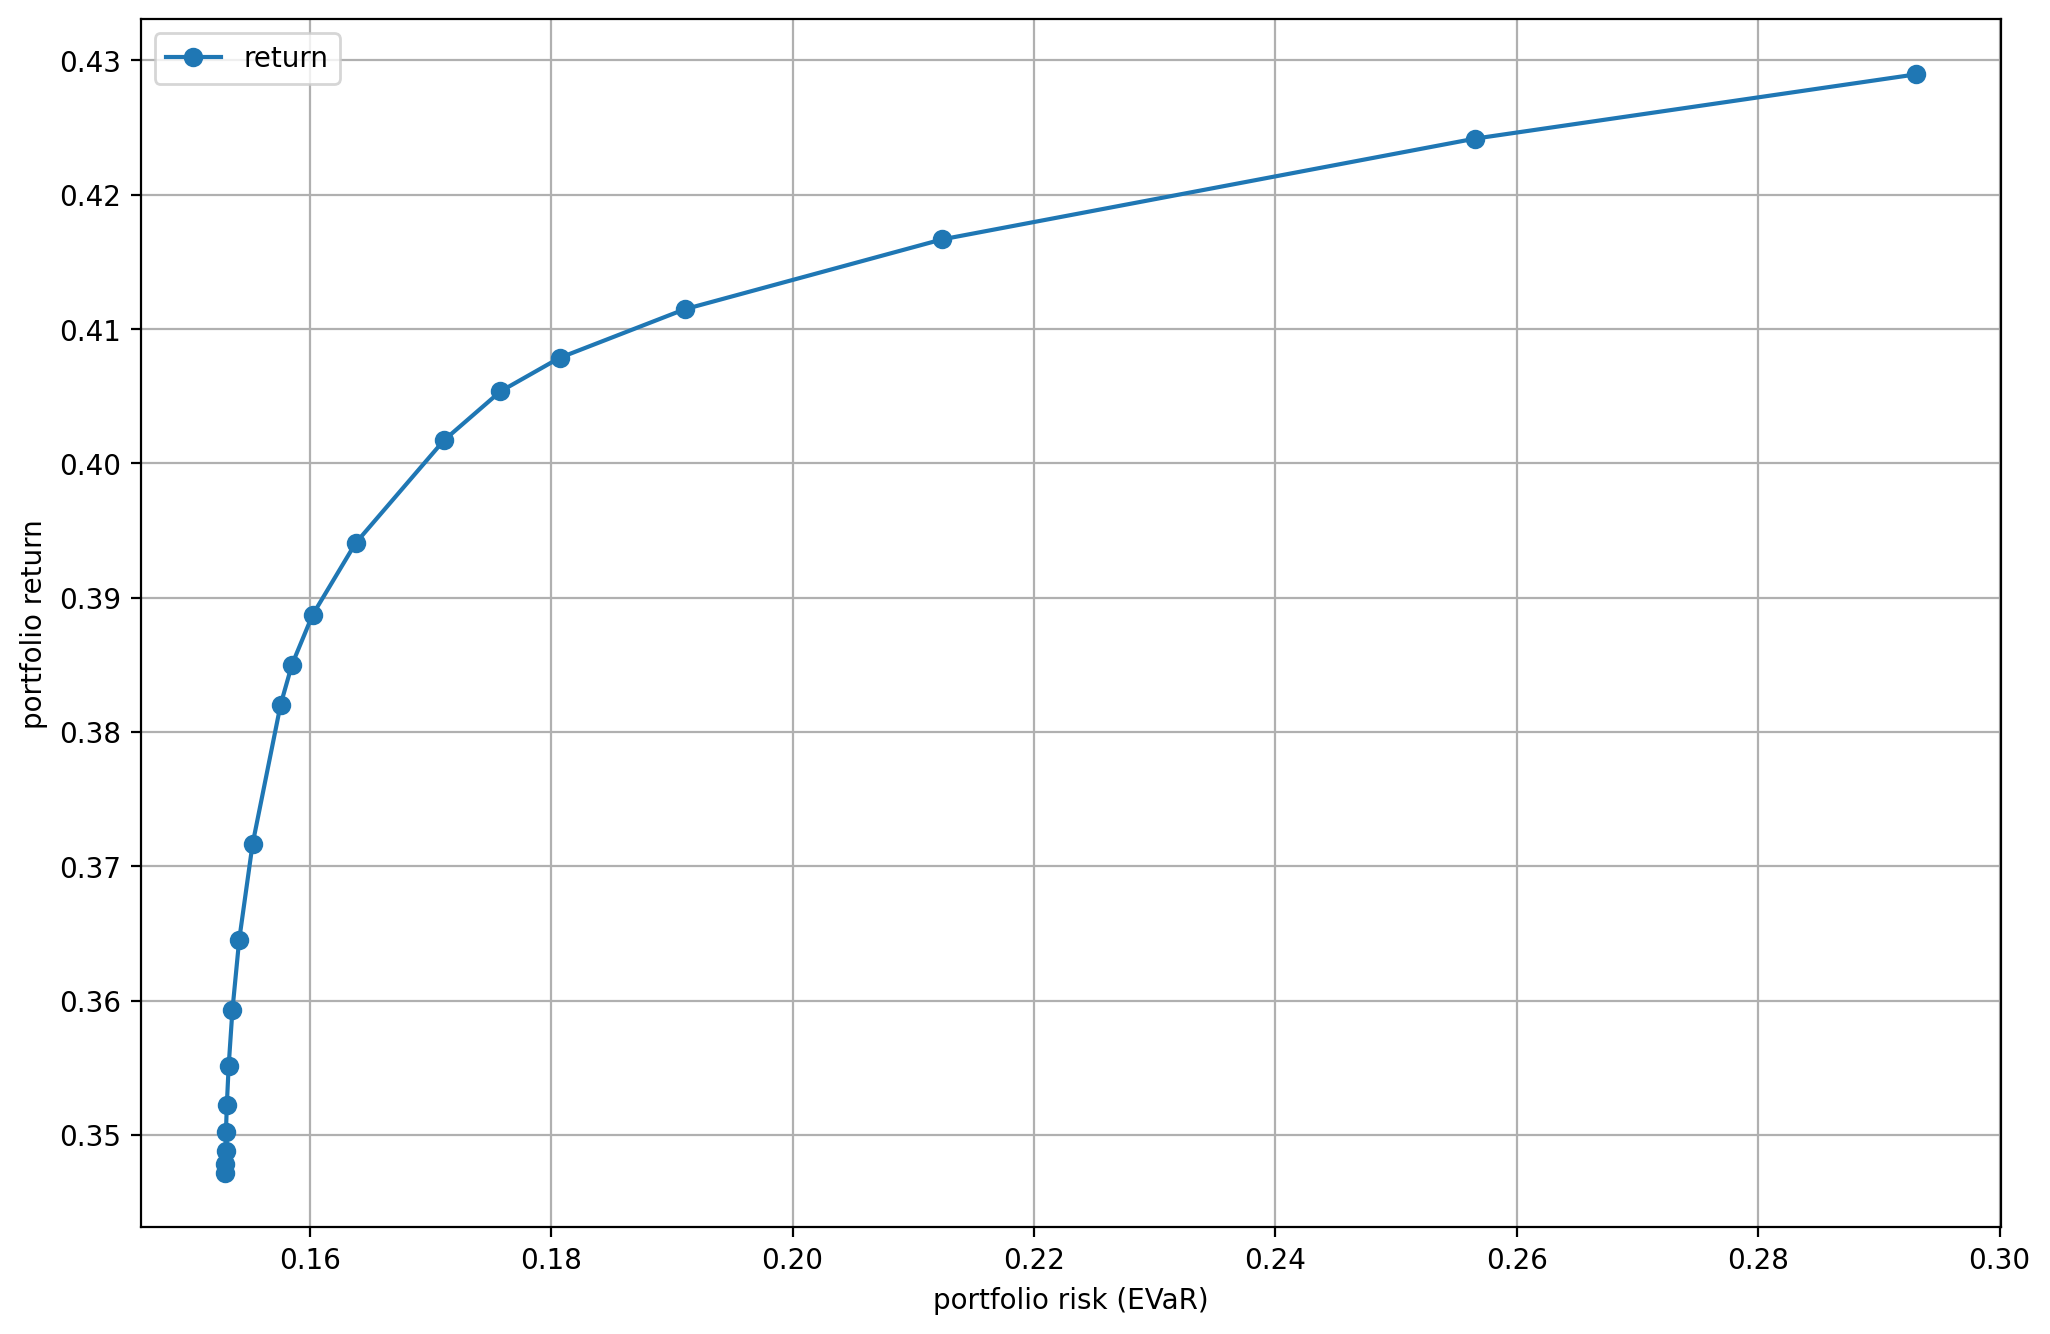

In [28]:
ax = df_result.plot(x="risk", y="return", style="-o", 
                    xlabel="portfolio risk (EVaR)", ylabel="portfolio return", grid=True)   
ax.legend(["return"]);

Plot the portfolio composition.

In [29]:
# Round small values to 0 to make plotting work
mask = np.absolute(df_result) < 1e-7
mask.iloc[:, :-8] = False
df_result[mask] = 0

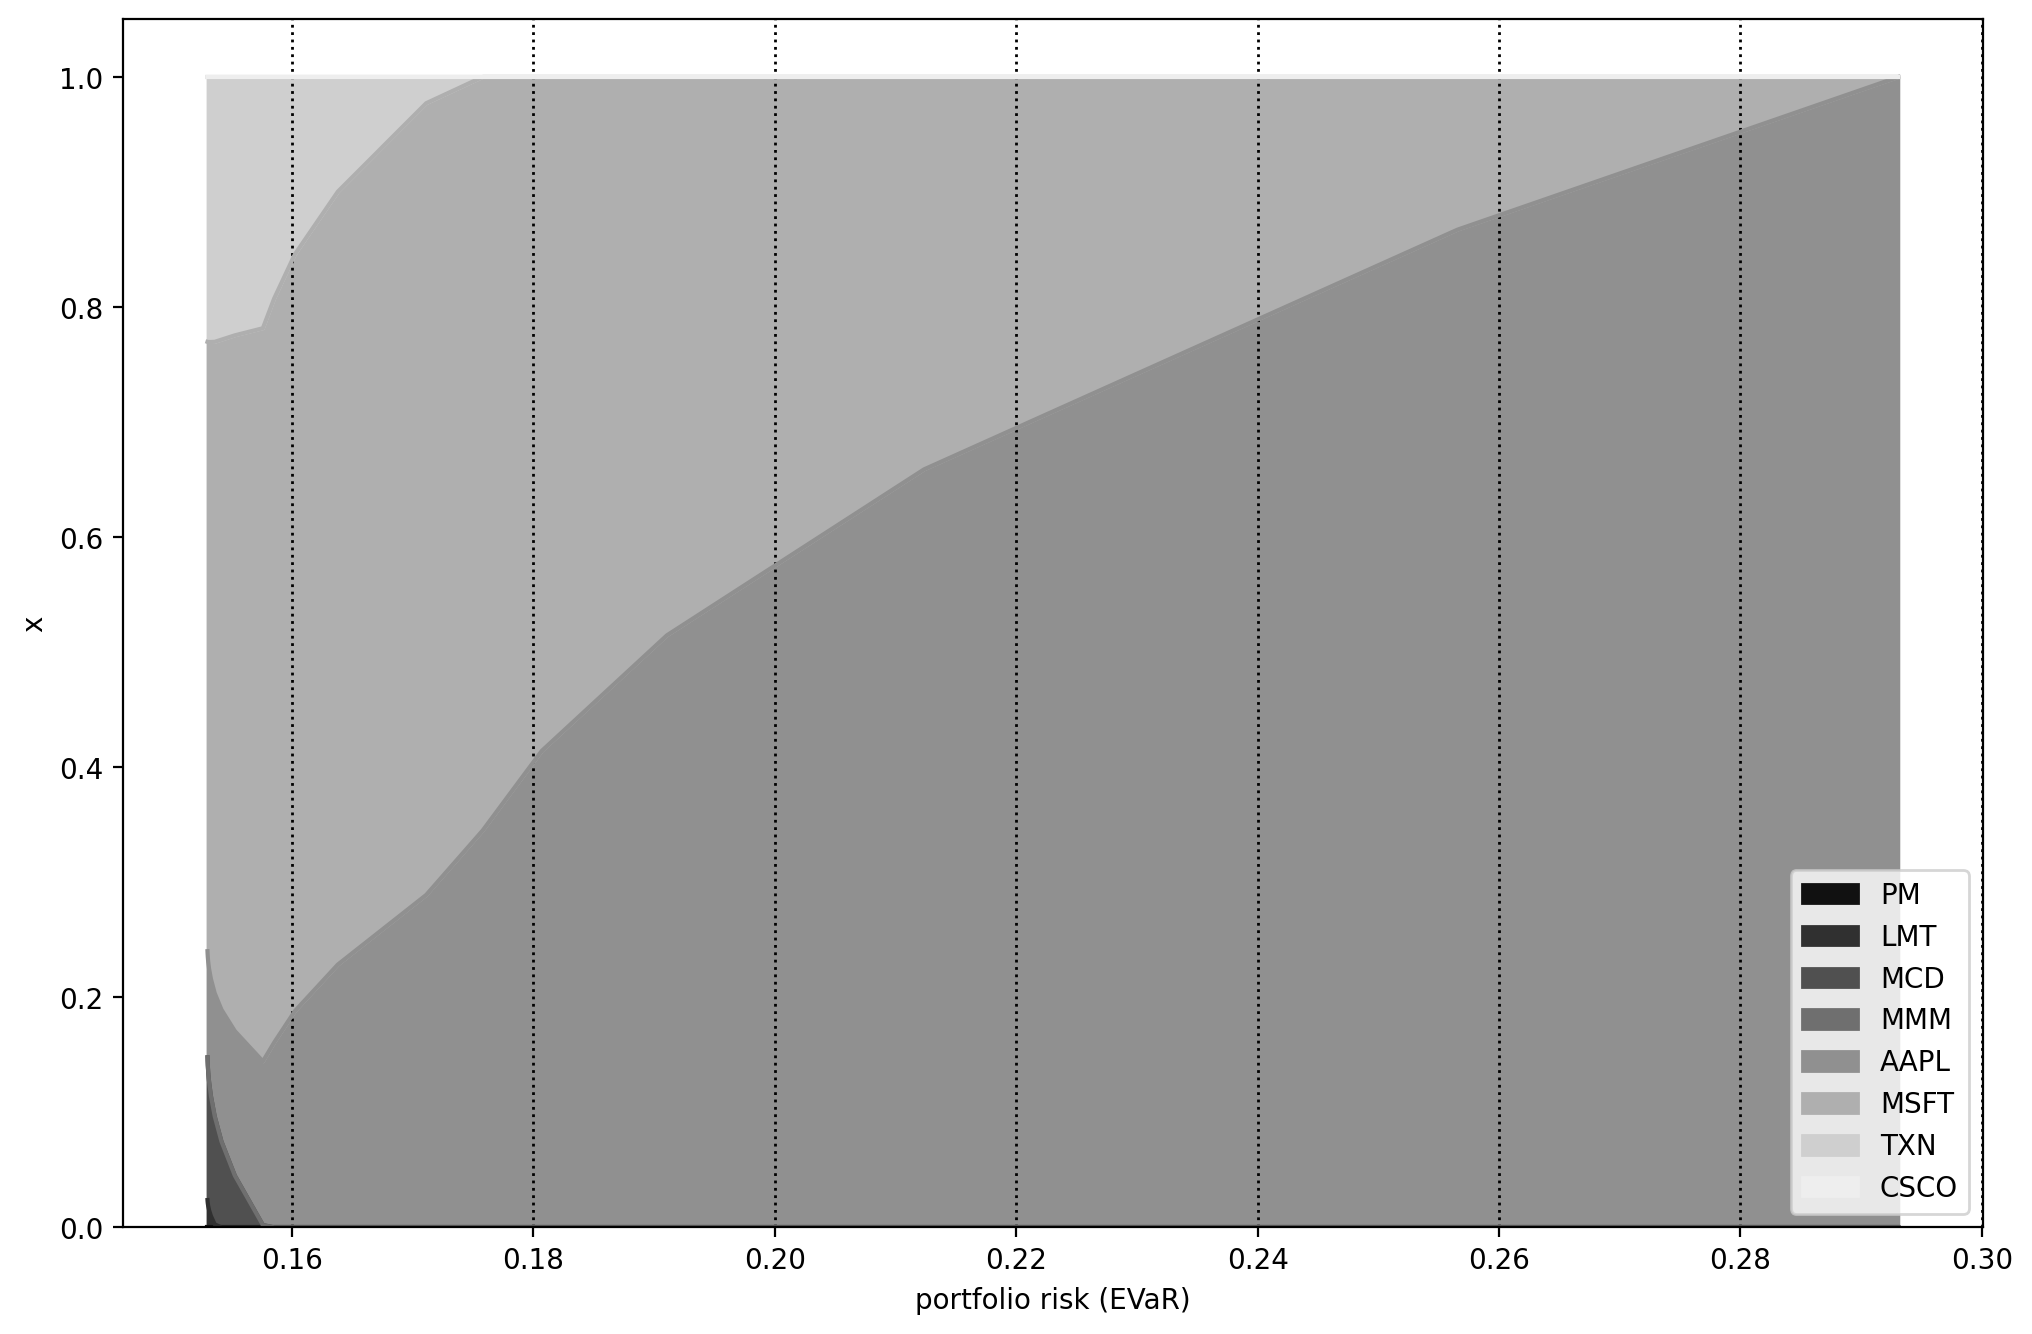

In [30]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = df_result.set_index('risk').iloc[:, 4:].plot.area(colormap=my_cmap, xlabel='portfolio risk (EVaR)', ylabel="x") 
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)